In [5]:
%pip install --upgrade pip
%pip install -r requirements.txt

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ---------------------------------------- 1.8/1.8 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


Note: you may need to restart the kernel to use updated packages.


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
df = pd.read_csv("prices/AAPL.csv", index_col=0)
df.head()

,date,open,high,low,close,volume,dividends,stock_splits
idx,,,,,,,,
1,1980-12-12,0.098726,0.099155,0.098726,0.098726,469033600,0.0,0.0
2,1980-12-15,0.094005,0.094005,0.093575,0.093575,175884800,0.0,0.0
3,1980-12-16,0.087136,0.087136,0.086707,0.086707,105728000,0.0,0.0
4,1980-12-17,0.088853,0.089282,0.088853,0.088853,86441600,0.0,0.0
5,1980-12-18,0.091429,0.091858,0.091429,0.091429,73449600,0.0,0.0


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cpu


In [25]:
from collections import deque
import random

class DQNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, action_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

class Agent:
    def __init__(self, state_size, window_size, trend, skip, batch_size):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.action_size = 3
        self.batch_size = batch_size
        self.memory = deque(maxlen=1000)
        self.inventory = []

        self.gamma = 0.95
        self.epsilon = 0.5
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999

        self.device = torch.device(DEVICE)
        self.model = DQNetwork(state_size, self.action_size).to(self.device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5)
        self.criterion = nn.MSELoss()

    def act(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        state = torch.tensor(state, dtype=torch.float32).to(self.device)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d:t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0:t + 1]
        res = [block[i + 1] - block[i] for i in range(window_size - 1)]
        return np.array(res, dtype=np.float32)

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        mini_batch = random.sample(self.memory, self.batch_size)

        states = np.array([transition[0] for transition in mini_batch])
        actions = np.array([transition[1] for transition in mini_batch])
        rewards = np.array([transition[2] for transition in mini_batch])
        next_states = np.array([transition[3] for transition in mini_batch])
        dones = np.array([transition[4] for transition in mini_batch])

        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).to(self.device)

        current_q = self.model(states).gather(1, actions.unsqueeze(1)).squeeze()
        next_q = self.model(next_states).max(1)[0].detach()
        target_q = rewards + (1 - dones) * self.gamma * next_q

        loss = self.criterion(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self, episodes):
        for episode in range(episodes):
            state = self.get_state(0)
            total_profit = 0
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.act(state)
                next_state = self.get_state(t + 1)
                reward = 0
                done = t == len(self.trend) - 2

                if action == 1 and t < (len(self.trend) - self.half_window):
                    self.inventory.append(self.trend[t])
                    reward = -self.trend[t]
                elif action == 2 and len(self.inventory) > 0:
                    bought_price = self.inventory.pop(0)
                    reward = self.trend[t] - bought_price
                    total_profit += reward

                self.memory.append((state, action, reward, next_state, done))
                state = next_state
                
                self.replay()

            print(f"Episode {episode + 1}/{episodes}, Total Profit: {total_profit}")

    def buy(self, initial_money):
        state = self.get_state(0)
        total_balance = initial_money
        states_buy = []
        states_sell = []
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(state)
            state = self.get_state(t + 1)
            if action == 1 and total_balance >= self.trend[t]:
                self.inventory.append(self.trend[t])
                total_balance -= self.trend[t]
                states_buy.append(t)

                print(f"Buying at {self.trend[t]} on time {t}, Balance: {total_balance}, Inventory: {len(self.inventory)}")
            elif action == 2 and len(self.inventory) > 0:
                bought_price = self.inventory.pop(0)
                total_balance += self.trend[t]
                states_sell.append(t)

                print(f"Selling at {self.trend[t]} on time {t}, Balance: {total_balance}, Inventory: {len(self.inventory)}")

        invest = ((initial_money - initial_money) / initial_money) * 100
        total_gains = initial_money - initial_money

        # return total_balance
        return states_buy, states_sell, total_gains, invest


In [ ]:
close = df.close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1
batch_size = 32
agent = Agent(state_size=window_size,
              window_size=window_size,
              trend=close,
              skip=skip,
              batch_size=batch_size)
agent.train(episodes=20)

In [ ]:
states_buy, states_sell, total_gains, invest = agent.buy(initial_money = initial_money)

Time 0, Action: 0, Balance: 10000, Inventory: 0
Time 1, Action: 0, Balance: 10000, Inventory: 0
Time 2, Action: 0, Balance: 10000, Inventory: 0
Time 3, Action: 0, Balance: 10000, Inventory: 0
Time 4, Action: 0, Balance: 10000, Inventory: 0
Time 5, Action: 0, Balance: 10000, Inventory: 0
Time 6, Action: 0, Balance: 10000, Inventory: 0
Time 7, Action: 0, Balance: 10000, Inventory: 0
Time 8, Action: 0, Balance: 10000, Inventory: 0
Time 9, Action: 0, Balance: 10000, Inventory: 0
Time 10, Action: 0, Balance: 10000, Inventory: 0
Time 11, Action: 0, Balance: 10000, Inventory: 0
Time 12, Action: 0, Balance: 10000, Inventory: 0
Time 13, Action: 0, Balance: 10000, Inventory: 0
Time 14, Action: 0, Balance: 10000, Inventory: 0
Time 15, Action: 0, Balance: 10000, Inventory: 0
Time 16, Action: 0, Balance: 10000, Inventory: 0
Time 17, Action: 0, Balance: 10000, Inventory: 0
Time 18, Action: 0, Balance: 10000, Inventory: 0
Time 19, Action: 0, Balance: 10000, Inventory: 0
Time 20, Action: 0, Balance: 1

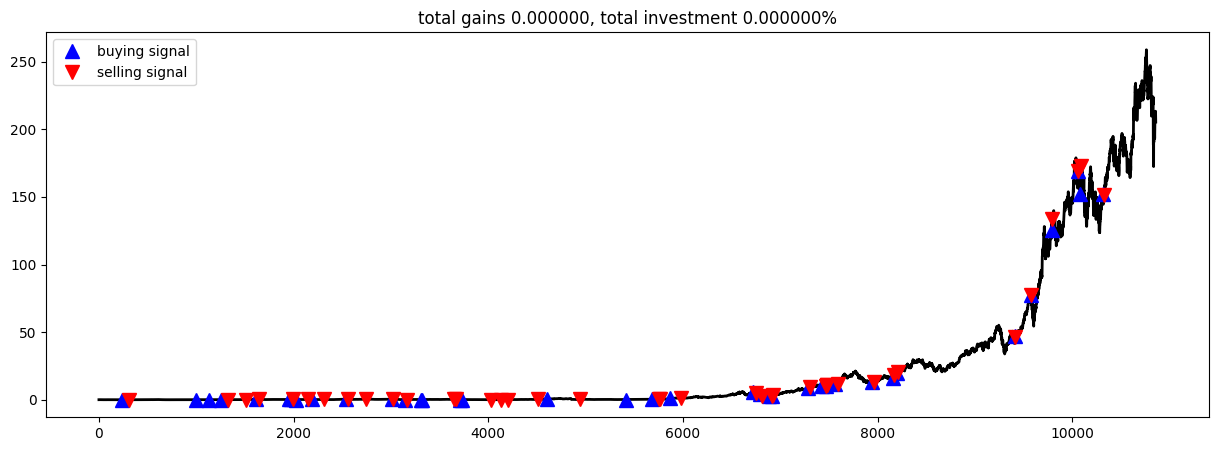

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='black', lw=2.)
plt.plot(close, '^', markersize=10, color='blue', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='red', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()